In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime
import numpy as np
import json
import calcutils as cu

# Задаем настройки (пути/имена файлов задать свои)

In [2]:
input_folder = "C:\\BitBucket\\nn_experiments\\Python\\ZzPythonProject\\WrtMarketResearch\\SourceData\\"
file_names = ["EURUSD1440.csv"]
output_folder = "C:\\BitBucket\\nn_experiments\\Python\\ZzPythonProject\\WrtMarketResearch\\ResultData\\"
out_zz_file_name_prefix = "Zz"
out_ind_file_name_prefix = "Ind"
ind_period = 1
bands_period = 5
std_bands = [-3, -2.4, -1.8, -1.2, -0.6, 0, 0.6, 1.2, 1.8, 2.4, 3]
indicator_functions = {
    "Gaps": "def Gaps(data) : res = data.open - data.close.shift(-1); data.drop(data.tail(1).index,inplace=True); return res",
    "ATR": "def ATR(data) : return data.high - data.low",
    "RangeBody": "def RangeBody(data) : return data.close - data.open",
    "RangeDown": "def RangeDown(data) : return data.open - data.low",
    "RangeUp": "def RangeUp(data) : return data.high - data.open"
  }
zz_level = 1
sequence_min_len = 3
sequence_max_len = 5
plot_last_samples = 0
float_precision = 5
csv_separator = ";"

In [3]:
def parse_date_time_str(date, time):
    date_time_str = f"{date} {time}"
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y.%m.%d %H:%M')
    return date_time_obj

In [4]:
def zz_out_format_df(rates_df, zz_df):
    zz = zz_df[zz_df.zigzag > 0]
    res = pd.DataFrame(index=zz.index)
    res["Vloj"] = zz_level
    res["t1"] = rates_df.apply(lambda row: parse_date_time_str(row["date"],row["time"]),axis=1)
    res["t2"] = res.t1.shift(-1)
    res["p1"] = zz_df.zigzag
    res["p2"] = res.p1.shift(-1)
    res["nPat4"] = zz.pattern
    res["zzlen"] = zz.zzlen
    return res

# Считаем данные для всех комбинаций file_names и indicator_functions

In [15]:
rates_df: pd.DataFrame
for file_name in file_names:
    for indicator_name in indicator_functions.keys():
        func_tmp_dict = {}
        exec(indicator_functions[indicator_name], func_tmp_dict)
        
        #Читаем входной файл
        rates_df = pd.read_csv(input_folder+file_name)
        
        #Инициализируем имя индикатора в хелпере "calcutils"
        cu.indicator = indicator_name
        
        #Считаем индикатор + полосы
        indicator = cu.calc_indicator(rates_df, func_tmp_dict[cu.indicator], ind_period)
        indicator = cu.calc_bands(indicator, std_bands, bands_period)
        
        #1.Разработка алгоритма ZigZag и расчет паттернов для индикатора ATR.
        zz = pd.DataFrame(indicator[cu.indicator])
        zz["zigzag"] = cu.calc_zigzag(zz, zz_level)
        zz["pattern"] = cu.calc_zz_pattern(zz)

        #2.Добавить признаки длины линий ZigZag — т.е. сколько свечей длится любая линия ZigZag.
        zz["zzlen"] = cu.calc_zz_ray_len(zz)
        
        #Пишем выходной файл с зигзагом для текущей функции
        zz_fname = f'{output_folder}{out_zz_file_name_prefix}_{indicator_name}_{file_name}'
        zz_out = zz_out_format_df(rates_df, zz)
        zz_out.to_csv(zz_fname, float_format=f'%.{float_precision}f', sep=csv_separator)
        print(f'Writing file {zz_fname}')
        
        #3.Добавить признаки стандартного отклонения для каждого бара — в какую из 12 зон отклонения попадает бар
        indicator["zone"] = cu.get_bollinger_zone(indicator, std_bands)
        
        #4.Добавить признак направления среднего значения (средняя линия Bollinger Bands) по отношению к предыдущему
        # своему значению для рассматриваемой последовательности. Растет или падает Moving Average на каждом из баров.
        indicator["bands_dir"] = cu.get_bollinger_direction(indicator, "Std_0")
        
        #5.Добавить признак разности между крайними Bollinger Bands на момент формирования паттерна для каждой свечи.
        indicator["bands_range"] = cu.get_bands_range(indicator, std_bands)
        
        #6.Добавить признак сравнения волатильности. Т.е насколько H-L текущего бара,
        # меньше или больше среднего ATR за последние 30 баров.
        indicator[f"HL-ATR{30}"] = cu.get_hl_atr_diff(rates_df, atr_period = 30)
        
        #Пишем выходной файл с индикатором для текущей функции
        ind_fname = f'{output_folder}{out_ind_file_name_prefix}_{indicator_name}_{file_name}'
        indicator["datetime"] = rates_df.apply(lambda row: parse_date_time_str(row["date"],row["time"]),axis=1)
        indicator.to_csv(ind_fname, float_format=f'%.{float_precision}f', sep=csv_separator)
        print(f'Writing file {ind_fname}')


Writing file C:\BitBucket\nn_experiments\Python\ZzPythonProject\WrtMarketResearch\ResultData\Zz_Gaps_EURUSD1440.csv
Writing file C:\BitBucket\nn_experiments\Python\ZzPythonProject\WrtMarketResearch\ResultData\Ind_Gaps_EURUSD1440.csv
Writing file C:\BitBucket\nn_experiments\Python\ZzPythonProject\WrtMarketResearch\ResultData\Zz_ATR_EURUSD1440.csv
Writing file C:\BitBucket\nn_experiments\Python\ZzPythonProject\WrtMarketResearch\ResultData\Ind_ATR_EURUSD1440.csv
Writing file C:\BitBucket\nn_experiments\Python\ZzPythonProject\WrtMarketResearch\ResultData\Zz_RangeBody_EURUSD1440.csv
Writing file C:\BitBucket\nn_experiments\Python\ZzPythonProject\WrtMarketResearch\ResultData\Ind_RangeBody_EURUSD1440.csv
Writing file C:\BitBucket\nn_experiments\Python\ZzPythonProject\WrtMarketResearch\ResultData\Zz_RangeDown_EURUSD1440.csv
Writing file C:\BitBucket\nn_experiments\Python\ZzPythonProject\WrtMarketResearch\ResultData\Ind_RangeDown_EURUSD1440.csv
Writing file C:\BitBucket\nn_experiments\Python\Zz

# ДЕМО: поэтапный расчет и визуализация на примере ATR

# Парсим входные данные

In [6]:
rates_df = pd.read_csv(input_folder+file_names[0])
rates_df.head(5)

,date,time,open,high,low,close,volume
0,1998.01.02,00:00,1.0880,1.0886,1.0826,1.0851,92
1,1998.01.05,00:00,1.0857,1.0887,1.0686,1.0719,265
2,1998.01.06,00:00,1.0719,1.0752,1.0645,1.0650,146
3,1998.01.07,00:00,1.0653,1.0757,1.0641,1.0711,175
4,1998.01.08,00:00,1.0706,1.0781,1.0672,1.0739,186


# Вычислим значения индикатора и полос Боллинжера, выведем результат для первых 10 баров:

In [7]:
#assign indicator column name based on indicator_functions dictionary Key
cu.indicator = "ATR"

func_tmp_dict = {}
exec(indicator_functions[cu.indicator], func_tmp_dict)

indicator = cu.calc_indicator(rates_df, func_tmp_dict[cu.indicator], ind_period)
indicator = cu.calc_bands(indicator, std_bands, bands_period)
indicator[[cu.indicator]+cu.get_bands_col_names(std_bands)].head(bands_period*2)

,ATR,Std_-3,Std_-2.4,Std_-1.8,Std_-1.2,Std_-0.6,Std_0,Std_0.6,Std_1.2,Std_1.8,Std_2.4,Std_3
0,0.0060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0109,-0.003479,-0.000411,0.002657,0.005724,0.008792,0.01186,0.014928,0.017996,0.021063,0.024131,0.027199
5,0.0105,0.000388,0.002862,0.005337,0.007811,0.010286,0.01276,0.015234,0.017709,0.020183,0.022658,0.025132
6,0.0101,0.009095,0.009428,0.009761,0.010094,0.010427,0.01076,0.011093,0.011426,0.011759,0.012092,0.012425
7,0.0070,0.004690,0.005756,0.006822,0.007888,0.008954,0.01002,0.011086,0.012152,0.013218,0.014284,0.015350
8,0.0078,0.004027,0.005073,0.006120,0.007167,0.008213,0.00926,0.010307,0.011353,0.012400,0.013447,0.014493
9,0.0102,0.004313,0.005275,0.006236,0.007197,0.008159,0.00912,0.010081,0.011043,0.012004,0.012965,0.013927


# Вычислим ЗигЗаг и его свойства (согласно пунктам ТЗ 1-2):

In [8]:
#1.Разработка алгоритма ZigZag и расчет паттернов для индикатора ATR.
zz = pd.DataFrame(indicator[cu.indicator])
zz["zigzag"] = cu.calc_zigzag(zz, zz_level)
zz["pattern"] = cu.calc_zz_pattern(zz)

#2.Добавить признаки длины линий ZigZag — т.е. сколько свечей длится любая линия ZigZag.
zz["zzlen"] = cu.calc_zz_ray_len(zz)

zz[zz.zigzag > 0].tail(15)

,ATR,zigzag,pattern,zzlen
5426,0.00530,0.00530,3.0,1.0
5427,0.00951,0.00951,7.0,1.0
5428,0.00605,0.00605,1.0,1.0
5429,0.01003,0.01003,9.0,1.0
5430,0.00507,0.00507,3.0,1.0
5431,0.00915,0.00915,7.0,1.0
5432,0.00631,0.00631,1.0,1.0
5434,0.00938,0.00938,9.0,2.0
5436,0.00621,0.00621,3.0,2.0
5437,0.00955,0.00955,8.0,1.0


# Вычислим свойства индикатора (согласно пунктам ТЗ 3-6)

In [9]:
#3.Добавить признаки стандартного отклонения для каждого бара — в какую из 12 зон отклонения попадает бар
indicator["zone"] = cu.get_bollinger_zone(indicator, std_bands)

#4.Добавить признак направления среднего значения (средняя линия Bollinger Bands) по отношению к предыдущему
# своему значению для рассматриваемой последовательности. Растет или падает Moving Average на каждом из баров.
indicator["bands_dir"] = cu.get_bollinger_direction(indicator, "Std_0")

#5.Добавить признак разности между крайними Bollinger Bands на момент формирования паттерна для каждой свечи.
indicator["bands_range"] = cu.get_bands_range(indicator, std_bands)

#6.Добавить признак сравнения волатильности. Т.е насколько H-L текущего бара,
# меньше или больше среднего ATR за последние 30 баров.
indicator[f"HL-ATR{30}"] = cu.get_hl_atr_diff(rates_df, atr_period = 30)

indicator.head(15)

,ATR,Std_-3,Std_-2.4,Std_-1.8,Std_-1.2,Std_-0.6,Std_0,Std_0.6,Std_1.2,Std_1.8,Std_2.4,Std_3,zone,bands_dir,bands_range,HL-ATR30
0,0.0060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0109,-0.003479,-0.000411,0.002657,0.005724,0.008792,0.01186,0.014928,0.017996,0.021063,0.024131,0.027199,6.0,NaN,0.030678,NaN
5,0.0105,0.000388,0.002862,0.005337,0.007811,0.010286,0.01276,0.015234,0.017709,0.020183,0.022658,0.025132,6.0,1.0,0.024744,NaN
6,0.0101,0.009095,0.009428,0.009761,0.010094,0.010427,0.01076,0.011093,0.011426,0.011759,0.012092,0.012425,5.0,-1.0,0.003330,NaN
7,0.0070,0.004690,0.005756,0.006822,0.007888,0.008954,0.01002,0.011086,0.012152,0.013218,0.014284,0.015350,4.0,-1.0,0.010661,NaN
8,0.0078,0.004027,0.005073,0.006120,0.007167,0.008213,0.00926,0.010307,0.011353,0.012400,0.013447,0.014493,5.0,-1.0,0.010467,NaN
9,0.0102,0.004313,0.005275,0.006236,0.007197,0.008159,0.00912,0.010081,0.011043,0.012004,0.012965,0.013927,8.0,-1.0,0.009613,NaN


# Визуальный тест

Для визуальной проверки зигзага строим последние 50 баров индикатора ATR, зигзага, средней линии Боллинжера. 

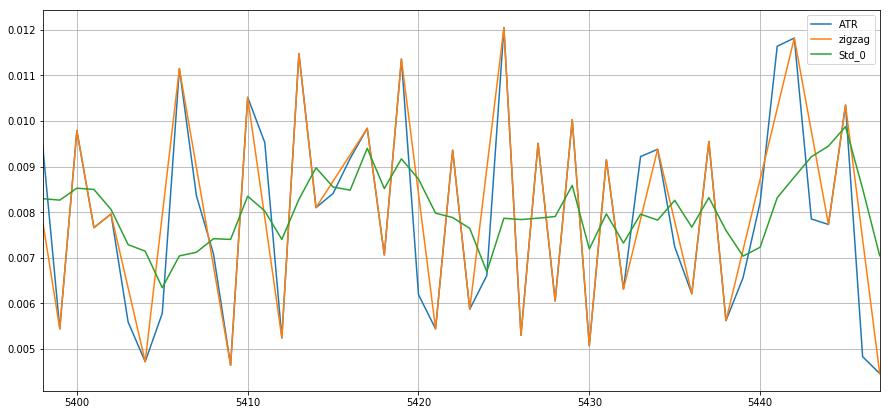

In [10]:
chart_df = pd.DataFrame(indicator[[cu.indicator] + cu.get_bands_col_names(std_bands)],
                        index = indicator.index)
chart_df["zigzag"] = zz["zigzag"]
chart_df["zigzag"] = chart_df.zigzag.replace(0, np.NAN).interpolate()
light_chart_df = chart_df[[cu.indicator,"zigzag","Std_0"]]
light_chart_df.tail(50).plot(figsize=(15,7), grid=True)

Построим для всех рисуемых полос:

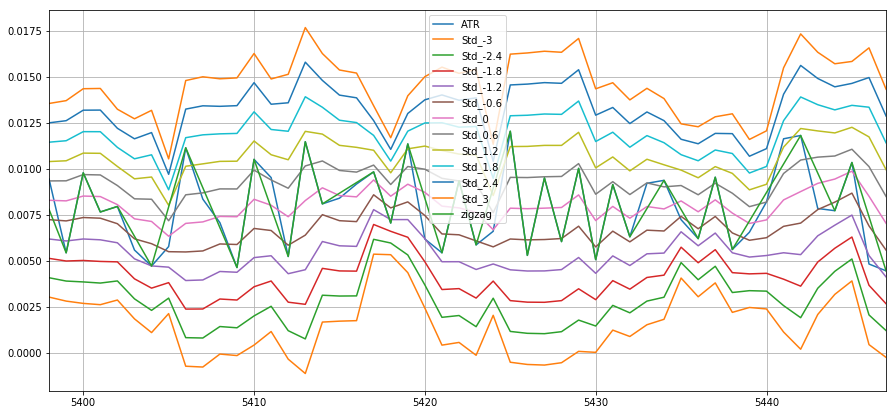

In [11]:
chart_df.tail(50).plot(figsize=(15,7), grid=True)